## Variable Setup for Baseline Classification Models

This script sets up the variables used in the models. This involves defining the site and the compound being explored, extracting the meteorological data and reading and balancing the 'true' baselines (obtained from Alaistair Manning at the Met Office). The data is then combined to create a dataframe that is saved for use in the models.

In [15]:
import pandas as pd
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'

import functions as f

site, site_name, compound = f.access_info()

print(f"Setting up data for \033[1m{compound}\033[0;0m at \033[1m{site_name}\033[0;0m.")

Setting up data for hfc-134a at Mace Head, Ireland.


In [16]:
# setting up balancing
minority_ratio = 0.8
using_balanced = True

#### Setting Up Variables

In [17]:
# extracting Manning's baseline flags for given site
df = f.read_manning(site)

# converting to xarray dataset
ds_flags = df.to_xarray()

In [18]:
# loading in meteorological data for given site
# 10m wind
ds_10m_u = xr.open_mfdataset((data_path/'meteorological_data'/'ECMWF'/site/'10m_wind_grid').glob('*u*.nc'))
ds_10m_v = xr.open_mfdataset((data_path/'meteorological_data'/'ECMWF'/site/'10m_wind_grid').glob('*v*.nc'))

# 850hPa wind
ds_850hPa_u = xr.open_mfdataset((data_path/'meteorological_data'/'ECMWF'/site/'850hPa_wind_grid').glob('*u*.nc'))
ds_850hPa_v = xr.open_mfdataset((data_path/'meteorological_data'/'ECMWF'/site/'850hPa_wind_grid').glob('*v*.nc'))

# 500hPa wind
ds_500hPa_u = xr.open_mfdataset((data_path/'meteorological_data'/'ECMWF'/site/'500hPa_wind_grid').glob('*u*.nc'))
ds_500hPa_v = xr.open_mfdataset((data_path/'meteorological_data'/'ECMWF'/site/'500hPa_wind_grid').glob('*v*.nc'))

# surface pressure
ds_sp = xr.open_mfdataset((data_path/'meteorological_data'/'ECMWF'/site/'surface_pressure').glob('*.nc'))

# boundary layer height
ds_blh = xr.open_mfdataset((data_path/'meteorological_data'/'ECMWF'/site/'boundary_layer_height').glob('*.nc'))

In [19]:
# grabbing the AGAGE data
# original data
# ds_agage = xr.open_dataset(data_path / f"AGAGE/data-gcms-nc/AGAGE-GCMS-Medusa_{site}_{compound}.nc")

# reprocessed data
ds_agage = xr.open_dataset(next((data_path / "AGAGE" / "AGAGE-public-files" / compound).glob(f"*{site}_{compound}.nc")))                 

In [20]:
# creating an xarray dataset with all the meteorological data, the AGAGE data, and the baseline flags, based on the flags time index
# adding a tolerance to the reindexing to allow for the AGAGE data to be reindexed to the nearest hour to avoid extrapolation of missing data
data_ds = xr.merge([ds_flags,
                    ds_10m_u.reindex(time=ds_flags.time, method='nearest'),
                    ds_10m_v.reindex(time=ds_flags.time, method='nearest'),
                    ds_850hPa_u.reindex(time=ds_flags.time, method='nearest'),
                    ds_850hPa_v.reindex(time=ds_flags.time, method='nearest'),
                    ds_500hPa_u.reindex(time=ds_flags.time, method='nearest'),
                    ds_500hPa_v.reindex(time=ds_flags.time, method='nearest'),
                    ds_sp.reindex(time=ds_flags.time, method='nearest'),
                    ds_blh.reindex(time=ds_flags.time, method='nearest'),
                    ds_agage.mf.reindex(time=ds_flags.time, method='nearest', tolerance=np.timedelta64(1, 'h'))],
                    compat='override',
                    combine_attrs='drop')

data_ds = data_ds.drop_vars('level')

# dropping any years after the final agage year
agage_years = np.unique(ds_agage['time.year'])
data_ds = data_ds.sel(time=data_ds['time.year'] <= agage_years[-1])

data_ds.to_netcdf(data_path/'saved_files'/f'data_ds_{compound}_{site}.nc')

In [21]:
# balancing the dataset
balanced_data_ds = f.balance_baselines(data_ds, minority_ratio)

# saving the balanced dataset
balanced_data_ds.to_netcdf(data_path/'saved_files'/f'data_balanced_ds_{compound}_{site}.nc')

In [28]:
# comparing the mole fraction time series for the original and balanced datasets
# calculating statistics
original_mf = data_ds.mf.values
original_mf = original_mf[~np.isnan(original_mf)]
balanced_mf = balanced_data_ds.mf.values
balanced_mf = balanced_mf[~np.isnan(balanced_mf)]

original_mean = original_mf.mean()
original_std = original_mf.std()
balanced_mean = balanced_mf.mean()
balanced_std = balanced_mf.std()

print(f"Original mean: {original_mean:.3f}, Balanced mean: {balanced_mean:.3f}. Percentage difference: {(abs(original_mean-balanced_mean)/original_mean)*100:.2f}%"
      f"\nOriginal std: {original_std:.3f}, Balanced std: {balanced_std:.3f}. Percentage difference: {(abs(original_std-balanced_std)/original_std)*100:.2f}%")

Original mean: 74.118, Balanced mean: 72.204. Percentage difference: 2.58%
Original std: 34.205, Balanced std: 34.150. Percentage difference: 0.16%


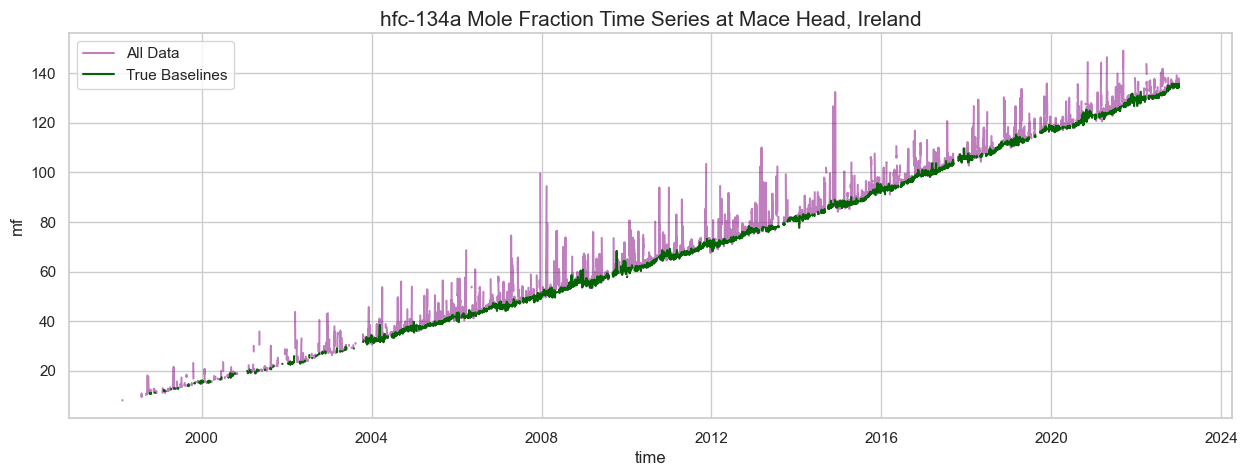

In [35]:
# plotting the mole fraction time series for the balanced dataset
fig, ax = plt.subplots(figsize=(15,5))
sns.set(style='whitegrid')

balanced_data_ds.mf.plot(ax=ax, label="All Data", color='purple', alpha=0.5)
balanced_data_ds.where(balanced_data_ds.baseline == 1, drop=True).mf.plot(ax=ax, label="True Baselines", color='darkgreen', linewidth=1.5)
ax.set_title(f"{compound} Mole Fraction Time Series at {site_name}", fontsize=15)
ax.legend()

In [36]:
if using_balanced == False:
    data_df = pd.DataFrame({"flag": data_ds.baseline.values}, index=data_ds.time.values)

    points = data_ds.points.values

    u10_columns = [f"u10_{point}" for point in points]
    v10_columns = [f"v10_{point}" for point in points]
    u850_columns = [f"u850_{point}" for point in points]
    v850_columns = [f"v850_{point}" for point in points]
    u500_columns = [f"u500_{point}" for point in points]
    v500_columns = [f"v500_{point}" for point in points]

    # concatenating the dataframe with the meteorological & temporal data
    data_df = pd.concat([
        data_df,
        pd.DataFrame(data_ds.u10.sel(points=points).values, columns=u10_columns, index=data_df.index),
        pd.DataFrame(data_ds.v10.sel(points=points).values, columns=v10_columns, index=data_df.index),
        pd.DataFrame(data_ds.u850.sel(points=points).values, columns=u850_columns, index=data_df.index),
        pd.DataFrame(data_ds.v850.sel(points=points).values, columns=v850_columns, index=data_df.index),
        pd.DataFrame(data_ds.u500.sel(points=points).values, columns=u500_columns, index=data_df.index),
        pd.DataFrame(data_ds.v500.sel(points=points).values, columns=v500_columns, index=data_df.index),
        pd.DataFrame({"sp": data_ds.sp.values}, index=data_df.index),
        pd.DataFrame({"blh": data_ds.blh.values}, index=data_df.index),
        pd.DataFrame({"time_of_day": data_df.index.hour}, index=data_df.index),
        pd.DataFrame({"day_of_year": data_df.index.dayofyear}, index=data_df.index)],
        axis=1)
    
elif using_balanced == True:
    data_df = pd.DataFrame({"flag": balanced_data_ds.baseline.values}, index=balanced_data_ds.time.values)

    points = balanced_data_ds.points.values

    u10_columns = [f"u10_{point}" for point in points]
    v10_columns = [f"v10_{point}" for point in points]
    u850_columns = [f"u850_{point}" for point in points]
    v850_columns = [f"v850_{point}" for point in points]
    u500_columns = [f"u500_{point}" for point in points]
    v500_columns = [f"v500_{point}" for point in points]

    # concatenating the dataframe with the meteorological & temporal data
    data_df = pd.concat([
        data_df,
        pd.DataFrame(balanced_data_ds.u10.sel(points=points).values, columns=u10_columns, index=data_df.index),
        pd.DataFrame(balanced_data_ds.v10.sel(points=points).values, columns=v10_columns, index=data_df.index),
        pd.DataFrame(balanced_data_ds.u850.sel(points=points).values, columns=u850_columns, index=data_df.index),
        pd.DataFrame(balanced_data_ds.v850.sel(points=points).values, columns=v850_columns, index=data_df.index),
        pd.DataFrame(balanced_data_ds.u500.sel(points=points).values, columns=u500_columns, index=data_df.index),
        pd.DataFrame(balanced_data_ds.v500.sel(points=points).values, columns=v500_columns, index=data_df.index),
        pd.DataFrame({"sp": balanced_data_ds.sp.values}, index=data_df.index),
        pd.DataFrame({"blh": balanced_data_ds.blh.values}, index=data_df.index),
        pd.DataFrame({"time_of_day": data_df.index.hour}, index=data_df.index),
        pd.DataFrame({"day_of_year": data_df.index.dayofyear}, index=data_df.index)],
        axis=1)

In [37]:
data_df = f.add_shifted_time(data_df, points)
data_df.index.name = "time"

data_df.head()

,flag,u10_0,u10_1,u10_2,u10_3,u10_4,u10_5,u10_6,u10_7,u10_8,...,v500_7_past,v500_8_past,v500_9_past,v500_10_past,v500_11_past,v500_12_past,v500_13_past,v500_14_past,v500_15_past,v500_16_past
time,,,,,,,,,,,,,,,,,,,,,
1989-02-04 13:00:00,1.0,10.788161,16.486134,6.606565,7.086873,4.888168,7.294574,10.317590,15.800560,18.524195,...,11.304873,42.114445,47.131565,19.717655,1.810524,5.039243,-5.359077,-8.649954,16.876099,19.250574
1989-02-04 15:00:00,1.0,11.400716,17.754244,8.383379,8.706288,4.028158,8.112394,10.217796,16.156734,18.775707,...,12.546279,14.061183,16.494265,44.895618,7.397734,6.317943,-10.694098,-6.783407,13.791235,6.989261
1989-02-04 17:00:00,1.0,12.272896,19.544037,9.218238,10.858747,4.755921,8.342001,9.963038,14.899172,19.462093,...,13.402297,13.704212,10.750771,18.501114,0.528272,5.744304,-11.154075,-7.197208,4.572162,-0.826795
1989-02-04 19:00:00,1.0,10.862803,19.999193,9.264483,11.764192,5.475571,8.959423,9.484354,14.024558,20.173630,...,7.035436,8.896655,11.406104,16.378826,2.650559,4.984188,-9.843408,-7.383686,1.782109,-3.151543
1989-02-04 21:00:00,1.0,10.378440,19.845852,10.878220,11.959723,6.494602,8.923725,8.335510,12.957659,19.458036,...,1.101911,2.972011,8.626707,14.773349,4.694704,4.497571,-10.143547,-7.230952,0.846171,-3.060968


In [39]:
# option for saving the dataframe for the model before dimensionality reduction
data_df.to_csv(data_path/'saved_files'/f"for_model_{compound}_{site}.csv")

#### Dimensionality Reduction

I'm reducing the dimensions of the dataset as has a huge number of features - can identify the most important features and remove noise.

N/A for neural network model.

##### Setting Up

In [ ]:
# dropping the flag column as it is the target variable - added back in later
data_for_pca = data_df.drop(columns='flag')

# dropping the temporal columns also
# data_for_pca = data_for_pca.drop(columns=['time_of_day', 'day_of_year'])

In [ ]:
# redefining column name lists to include shifted wind data
u10_columns = [col for col in data_for_pca.columns if 'u10' in col]
v10_columns = [col for col in data_for_pca.columns if 'v10' in col]
u850_columns = [col for col in data_for_pca.columns if 'u850' in col]
v850_columns = [col for col in data_for_pca.columns if 'v850' in col]
u500_columns = [col for col in data_for_pca.columns if 'u500' in col]
v500_columns = [col for col in data_for_pca.columns if 'v500' in col]

wind_columns = u10_columns + v10_columns + u850_columns + v850_columns + u500_columns + v500_columns

In [ ]:
# standardising the data for PCA based on column groups
# groups = wind (groups by direction and height), sp, blh, time_of_day, day_of_year
column_groups = {
    'u10': u10_columns,
    'v10': v10_columns,
    'u850': u850_columns,
    'v850': v850_columns,
    'u500': u500_columns,
    'v500': v500_columns,
    'sp': ['sp'],
    'blh': ['blh'],
    'time_of_day': ['time_of_day'],
    'day_of_year': ['day_of_year']
}

# creating dictionary to hold standardised data
standardised_data = {}

# standardising each group of columns
for group, columns in column_groups.items():
    data = data_for_pca[columns]
    
    # reshape if only one column - applicable for all but the wind columns
    if data.shape[1] == 1:
        data = data.values.reshape(-1, 1)
    
    standardised_data[group] = StandardScaler().fit_transform(data)


# concatenating the standardised data into a dataframe for use in PCA
# first converting the standardised data into dataframes so dimensions are correct for concatenation
dfs = [pd.DataFrame(data, columns=columns) for group, columns, data in zip(column_groups.keys(), column_groups.values(), standardised_data.values())]

# concatenating the dataframes
data_for_pca = pd.concat(dfs, axis=1)

data_for_pca.index = data_df.index

##### Fitting PCA

In [ ]:
desired_explained_variance = 0.85

In [ ]:
# exploring the explained variance ratio for different numbers of components to find the optimal number of components
# fitting the PCA with the standardised data
pca = PCA()
pca.fit(data_for_pca)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# plotting the cumulative explained variance
fig, ax = plt.subplots(figsize=(8,6))
sns.set(style='darkgrid')
sns.set_palette("colorblind")

ax.plot(cumulative_variance)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Explained Variance')
ax.set_title('Cumulative Explained Variance vs. Number of Components')

# adding a horizontal line at the desired explained variance
ax.axhline(y=desired_explained_variance, color='r', linestyle='--', alpha=0.7)

# annotating plot with the corresponding number of components
desired_components = np.argmax(cumulative_variance >= desired_explained_variance) + 1
ax.annotate(f'{desired_explained_variance*100:.0f}% Explained Variance = {desired_components} components',
             xy=(desired_components, desired_explained_variance), xycoords='data',
             xytext=(0, -30), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='black'),
             fontsize=9, color='black')

In [ ]:
# fitting the PCA with the desired number of components (20)
# num_components = desired_components
num_components = 20
pca = PCA(n_components=num_components)

# fitting the PCA with my data
pca_data = pca.fit_transform(data_for_pca)
pca_components = pd.DataFrame(pca_data, columns=[f"PC{i+1}" for i in range(num_components)], index=data_df.index)
pca_components.sample(5)

In [ ]:
# retrieving the loading for each component
loadings = pd.DataFrame(pca.components_.T, columns=[f"PC{i+1}" for i in range(num_components)], index=data_for_pca.columns)

# saving the loadings to a csv file
loadings.to_csv(data_path/'saved_files'/f"pca_loadings_{compound}_{site}.csv")

In [ ]:
# plotting a cumulative explained variance plot for the PCA components
features = range(pca.n_components_)
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(8,6))
sns.set(style='darkgrid')
sns.set_palette("colorblind")

ax.bar(features, pca.explained_variance_ratio_, color='black')
ax.step(range(1,(pca_components.shape[1]+1)), cum_var_exp, where='mid', label='Cumulative Explained Variance')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Explained Variance')
ax.set_title('Exploring the Explained Variance of PCA Components')
ax.legend()

In [ ]:
# adding the flag column back in and saving the dataframe for use in the model
pca_components['flag'] = data_df['flag']

# adding back temporal variables
# pca_components['time_of_day'] = data_df['time_of_day']
# pca_components['day_of_year'] = data_df['day_of_year']

# saving the PCA components dataframe
pca_components.to_csv(data_path/'saved_files'/f'for_model_pca_{compound}_{site}.csv', index=True)

In [ ]:
pca = pd.read_csv(data_path/'saved_files'/f'for_model_pca_{compound}_{site}.csv', index_col=0)
pca